In [57]:
###### Global Variable 
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' #'robbert-base-cased'
PATH_to_attack_data="/content/drive/MyDrive/adversarial-examples-in-text-classification/imdb__textattackbert-base-uncased-imdb_bert__pwws.csv"
PATH_to_saved_model="/content/drive/MyDrive/cache/best_model_state.bin"



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [6]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import torch
torch.cuda.empty_cache()
import pandas as pd
import torch.nn.functional as F
import numpy as np



from collections import defaultdict
from torch import  nn 
from datasets import load_dataset
from transformers import BertTokenizer, BertModel,AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load dataset

In [10]:
df= datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Data preprocessing

In [12]:

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [13]:
token_lens = []

for txt in df['train']['text'][:1000]:
  tokens = tokenizer.encode(txt, max_length=1024)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-14-a3be3d0f906e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


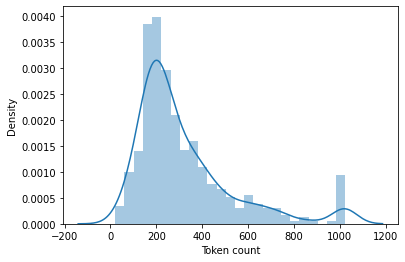

In [14]:
sns.distplot(token_lens)
plt.xlabel('Token count');
plt.show()

Most of the reviews seems to contain less than 400 tokens, but we'll be on the 

---

safe side and choose a maximum length of 512.

In [15]:
MAX_LEN = 512

### Building a sentiment classifier that we will use for odd

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [16]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [17]:

df_train = pd.DataFrame(df['train'] )
df_test=pd.DataFrame(df['test'] )
df=pd.concat([df_train,df_test],axis=0)

In [18]:

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [19]:
df_train.shape, df_val.shape, df_test.shape

((45000, 2), (2500, 2), (2500, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [21]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Sentiment classification with Bert

In [22]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [24]:
model = SentimentClassifier(2)
model.load_state_dict(torch.load(PATH_to_saved_model))### to load  save model
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [25]:

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

:

### Evaluation of model

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("The score of our model:",test_acc.item())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

The score of our model: 0.936


#### ODD WITH MAX SOFTMAX

In [101]:
clean_adversarial_sample=pd.read_csv(PATH_to_attack_data)[['text','result_type']]

In [102]:
clean_adversarial_sample

,text,result_type
0,If you want to see a film starring Stan laurel...,1
1,"It pays to watch Reader's Digest. Or Time, if ...",1
2,Thereafter again Woody Allen seems to be compl...,1
3,Disseminate pro-American war effort film that ...,1
4,One of the most interesting things is that thi...,1
...,...,...
4183,I enjoyed this film immensely. I'm really into...,0
4184,This movie had potential to be a good little h...,0
4185,"If you love Chan-wook Park, you know what to e...",0
4186,The DVD release of this movie hopes you will b...,0


In [103]:
attack=clean_adversarial_sample[clean_adversarial_sample.result_type==1]
clean= df_train.iloc[:len(attack),:]
clean['result_type']=0
attack_clean=pd.concat([attack,clean[['text','result_type']]])


<ipython-input-103-09ae025c22cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['result_type']=0


In [104]:
def create_attack_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    tokenizer=tokenizer,
    targets=df.result_type.to_numpy(),
    max_len=max_len
  )

  return (DataLoader(
    ds,
    batch_size=batch_size,
  ))
attack_data_loader = create_attack_data_loader(attack_clean, tokenizer, MAX_LEN, BATCH_SIZE)

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

In [105]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      max_output, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Now we calculate our probability at the last layer

In [106]:
y_review_texts, y_pred, y_pred_probs,attack_label_real = get_predictions(
  model,
  attack_data_loader
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Get the max of softmax  for odd

In [107]:
 prob=np.amax(y_pred_probs.numpy(), axis=1)
 prob

array([0.98479605, 0.99681634, 0.98471653, ..., 0.9541743 , 0.9976611 ,
       0.9991316 ], dtype=float32)

In [108]:
attack_label_real

tensor([1, 1, 1,  ..., 0, 0, 0])

In [109]:
from sklearn import metrics
fpr, tpr,thresholds = metrics.roc_curve(attack_label_real,prob, pos_label=0)
print('AUROC:',metrics.auc(fpr, tpr))

AUROC: 0.7412651237127227


In [110]:
from sklearn.metrics import average_precision_score

print('AUPR:',average_precision_score(attack_label_real,prob,pos_label=0))

AUPR: 0.7417240459326082


# OOD prediction

In [111]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


def get_max_softmax(probas):
  prob = np.amax(probas.numpy(), axis=1)
  return prob 

def get_scores(label, proba, method = 'Max softmax', pos_lab=0):
  fpr, tpr,thresholds = metrics.roc_curve(label,proba, pos_label=pos_lab)
  auroc = round(metrics.auc(fpr, tpr),3)
  aupr = round(average_precision_score(attack_label_real,proba,pos_label=pos_lab),3)

  print(method + ' AUROC:', auroc)
  print(method + ' AUPR:', aupr)

  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr))
  display.plot()
  plt.show()

  return auroc,aupr


####################################

def docteur_discriminator_alpha(probas, gamma):
  res = (probas**2).sum(axis = 1)
  desc =  (1 - res > gamma*res)
  desc = desc.int()
  return res, desc

In [112]:
# Max softmax probabilities
prob = get_max_softmax(y_pred_probs)

# doctor score
gamma = 1
doc_alpha, pred_doctor = docteur_discriminator_alpha(y_pred_probs, gamma)

Scores for softmax
Max softmax AUROC: 0.741
Max softmax AUPR: 0.742


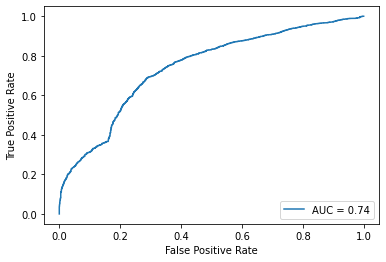


Scores for Doctor
Doctor alpha AUROC: 0.741
Doctor alpha AUPR: 0.742


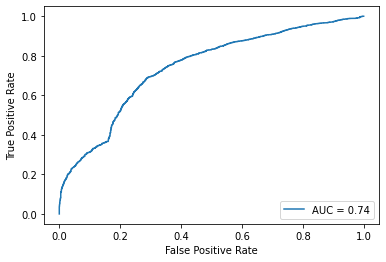

In [113]:
#scores 
print('Scores for softmax')
auc, aupr = get_scores(attack_label_real, prob)
print()
print('Scores for Doctor')
auc2, aupr2 = get_scores(attack_label_real, doc_alpha, 'Doctor alpha')

In [114]:
data = np.array([np.array(y_pred),np.array(attack_label_real), prob, np.array(doc_alpha)])

In [115]:
dataset = pd.DataFrame({'target': data[0, :],'attack_res': data[1, :], 'max_softmax_score': data[2, :], 'doctor_score': data[3, :]})
dataset.head()

,target,attack_res,max_softmax_score,doctor_score
0,1.0,1.0,0.984796,0.970054
1,1.0,1.0,0.996816,0.993653
2,0.0,1.0,0.984717,0.969900
3,0.0,1.0,0.940302,0.887733
4,1.0,1.0,0.975717,0.952614


Text(0.5, 1.0, 'ddd')

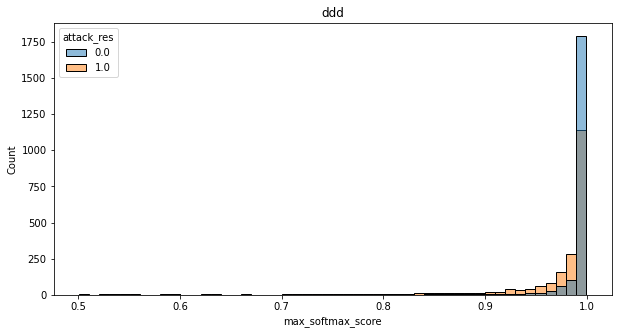

In [134]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.histplot(data=dataset, x="max_softmax_score", hue="attack_res",bins=50)
plt.title('ddd')


Text(0.5, 1.0, 'ddd')

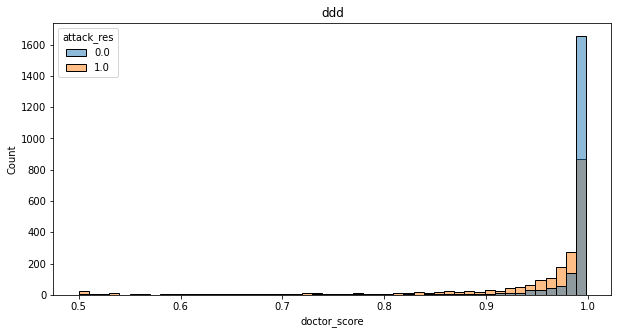

In [135]:
plt.figure(figsize=(10,5))
sns.histplot(data=dataset, x="doctor_score", hue="attack_res",bins=50)
plt.title('ddd')

## Manhalobis

In [118]:
def get_predictions(model, data_loader):
  model = model.eval()

  out_put_value=[]
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # _, preds = torch.max(outputs, dim=1)

      # probs = F.softmax(outputs, dim=1)

      # review_texts.extend(texts)
      # predictions.extend(preds)
      # prediction_probs.extend(probs)
      real_values.extend(targets)
      out_put_value.extend(outputs)

  out_put_value = torch.stack(out_put_value).cpu()
  real_values = torch.stack(real_values).cpu()
  return  out_put_value.cpu().numpy(), real_values.numpy()

In [119]:
clean_data_loader = create_data_loader(df_train.iloc[:len(attack),:], tokenizer, MAX_LEN, BATCH_SIZE)
output_val_in, label=get_predictions(model,clean_data_loader)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(

In [120]:
out_distribution_data=create_attack_data_loader(attack, tokenizer, MAX_LEN, BATCH_SIZE)
output_val_out,_=get_predictions(model,out_distribution_data)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [121]:
def compute_mean_class(valeur,label):
  label_0=pd.DataFrame(label).value_counts()[0]
  label_1=pd.DataFrame(label).value_counts()[1]
  u_0=np.dot(valeur.T,(label==0).astype(int))/label_0
  u_1=np.dot(valeur.T,label)/label_1
  return u_0,u_1



In [122]:
def compute_inverse_covariance(valeur,label):
 cov_matrix=(pd.DataFrame(valeur)[label==0].cov()+pd.DataFrame(valeur)[label==1].cov()).to_numpy()
 inv_cov_matrix = np.linalg.inv(cov_matrix)
 return inv_cov_matrix

In [123]:
def mahalanobis_distance(x, mean_by_class, in_cov):
  distances=[]
  for i in range(len(mean_by_class)):
    diff=x-mean_by_class[i]
    distances.append(np.dot(np.dot((diff),in_cov),diff.T))

  return max(np.array(distances)*-1)

In [124]:
mean_by_class=compute_mean_class(output_val_in,label)
in_cov=compute_inverse_covariance(output_val_in,label)

In [125]:
distance_in=[mahalanobis_distance(val, mean_by_class, in_cov) for val in output_val_in]
distance_out=[mahalanobis_distance(val, mean_by_class, in_cov) for val in output_val_out]

In [126]:
size=len(distance_out)
distance=distance_in[:size]+distance_out
label=[0 for i in range(size)]+[1 for i in range(size)]

In [127]:
from sklearn import metrics
fpr, tpr,thresholds = metrics.roc_curve(label,distance, pos_label=0)
print('AUROC:',metrics.auc(fpr, tpr))

AUROC: 0.6242949565274505


MHLNB AUROC: 0.624
MHLNB AUPR: 0.45


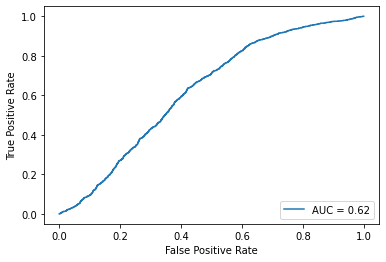

(0.624, 0.45)

In [133]:
get_scores(label, distance, 'MHLNB')

In [129]:
dataset['mhlnb'] = distance

Text(0.5, 1.0, 'ddd')

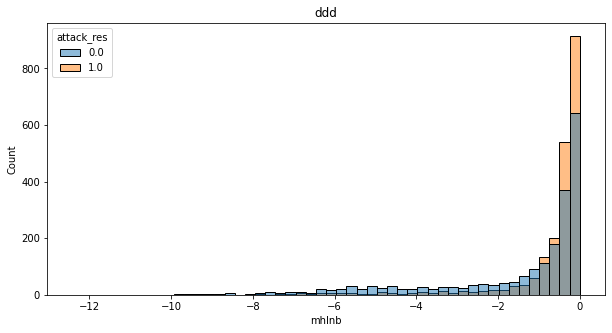

In [136]:
plt.figure(figsize=(10,5))
sns.histplot(data=dataset, x="mhlnb", hue="attack_res",bins=50)
plt.title('ddd')